In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from refactor import GNNAD

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
X_train = pd.read_csv(f"./data/msl/train.csv", sep=",", index_col=0)
X_train = X_train.drop(columns=["attack"]) if "attack" in X_train.columns else X_train
X_test = pd.read_csv(f"./data/msl/test.csv", sep=",", index_col=0)
y_test = X_test.attack.tolist()

# Model

In [3]:
model = GNNAD(shuffle_train=False)
fitted_model = model.fit(X_train, X_test, y_test)

epoch (0 / 100) (Loss:0.80658589, ACU_loss:2.41975766)
epoch (1 / 100) (Loss:0.70174988, ACU_loss:2.10524964)
epoch (2 / 100) (Loss:0.63414681, ACU_loss:1.90244043)
epoch (3 / 100) (Loss:0.56905279, ACU_loss:1.70715836)
epoch (4 / 100) (Loss:0.50592784, ACU_loss:1.51778352)
epoch (5 / 100) (Loss:0.44875027, ACU_loss:1.34625080)
epoch (6 / 100) (Loss:0.40624077, ACU_loss:1.21872231)
epoch (7 / 100) (Loss:0.36984242, ACU_loss:1.10952726)
epoch (8 / 100) (Loss:0.34269124, ACU_loss:1.02807373)
epoch (9 / 100) (Loss:0.31346307, ACU_loss:0.94038922)
epoch (10 / 100) (Loss:0.30232523, ACU_loss:0.90697569)
epoch (11 / 100) (Loss:0.29082531, ACU_loss:0.87247594)
epoch (12 / 100) (Loss:0.27879331, ACU_loss:0.83637993)
epoch (13 / 100) (Loss:0.26880477, ACU_loss:0.80641432)
epoch (14 / 100) (Loss:0.25651600, ACU_loss:0.76954800)
epoch (15 / 100) (Loss:0.25274762, ACU_loss:0.75824286)
epoch (16 / 100) (Loss:0.24726863, ACU_loss:0.74180590)
epoch (17 / 100) (Loss:0.24475727, ACU_loss:0.73427182)
ep

In [4]:
model = GNNAD(shuffle_train=False, threshold_type="max_validation")
fitted_model = model.fit(X_train, X_test, y_test)

epoch (0 / 100) (Loss:0.80658589, ACU_loss:2.41975766)
epoch (1 / 100) (Loss:0.70174988, ACU_loss:2.10524964)
epoch (2 / 100) (Loss:0.63414681, ACU_loss:1.90244043)
epoch (3 / 100) (Loss:0.56905279, ACU_loss:1.70715836)
epoch (4 / 100) (Loss:0.50592784, ACU_loss:1.51778352)
epoch (5 / 100) (Loss:0.44875027, ACU_loss:1.34625080)
epoch (6 / 100) (Loss:0.40624077, ACU_loss:1.21872231)
epoch (7 / 100) (Loss:0.36984242, ACU_loss:1.10952726)
epoch (8 / 100) (Loss:0.34269124, ACU_loss:1.02807373)
epoch (9 / 100) (Loss:0.31346307, ACU_loss:0.94038922)
epoch (10 / 100) (Loss:0.30232523, ACU_loss:0.90697569)
epoch (11 / 100) (Loss:0.29082531, ACU_loss:0.87247594)
epoch (12 / 100) (Loss:0.27879331, ACU_loss:0.83637993)
epoch (13 / 100) (Loss:0.26880477, ACU_loss:0.80641432)
epoch (14 / 100) (Loss:0.25651600, ACU_loss:0.76954800)
epoch (15 / 100) (Loss:0.25274762, ACU_loss:0.75824286)
epoch (16 / 100) (Loss:0.24726863, ACU_loss:0.74180590)
epoch (17 / 100) (Loss:0.24475727, ACU_loss:0.73427182)
ep

In [22]:
from torchsummary import summary

summary(fitted_model.model, (fitted_model.n_nodes, fitted_model.slide_win))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 64]           1,728
         Embedding-2                   [-1, 64]           1,728
            Linear-3                   [-1, 64]             960
        GraphLayer-4                   [-1, 64]              64
       BatchNorm1d-5                   [-1, 64]             128
              ReLU-6                   [-1, 64]               0
          GNNLayer-7                   [-1, 64]               0
         Embedding-8                   [-1, 64]           1,728
       BatchNorm1d-9               [-1, 64, 27]             128
          Dropout-10               [-1, 27, 64]               0
           Linear-11                [-1, 27, 1]              65
         OutLayer-12                [-1, 27, 1]               0
Total params: 6,529
Trainable params: 6,465
Non-trainable params: 64
----------------------------------

# Plot

In [10]:
fitted_model.model_path

'./pretrained/msl/0106-115219.pt'

In [67]:
import torch
from torch.utils.data import DataLoader

# read in best model
fitted_model.model.load_state_dict(torch.load(fitted_model.model_path))
best_model = fitted_model.model.to(fitted_model.device)

# get data with single batch
plot_dataloader = DataLoader(
    fitted_model.test_dataset,
    batch_size=1,
    shuffle=False,
)
# fitted_model._test(best_model, plot_dataloader)

# find alpha for single iter of x
x, y, labels, edge_index = next(iter(plot_dataloader))
x, y, labels, edge_index = [
    item.to("cpu").float() for item in [x, y, labels, edge_index]
]
best_model(x).float().to(fitted_model.device)

# weights
_alpha = fitted_model.model.gnn_layers[0].gnn.alpha

# topk edge index
topk_indices_ji = fitted_model.model.learned_graph
gated_i = (
    torch.arange(0, fitted_model.n_nodes)
    .repeat_interleave(fitted_model.topk)
    .unsqueeze(0)
    .to("cpu")
)  # [N x topk]
gated_j = topk_indices_ji.flatten().unsqueeze(0)  # [N x topk]
gated_edge_index = torch.cat((gated_j, gated_i), dim=0)  # [2, (N x topk)]
edge_index_ = gated_edge_index.long()

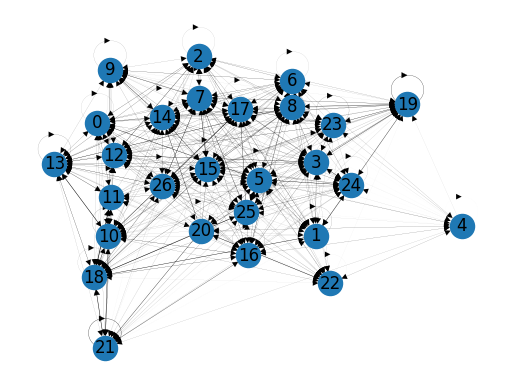

In [69]:
import networkx as nx

# edge_index_[1] #i is the index of node, repeated k times
# edge_index_[0] #j is the index of the neighbour

# create a graph object, add n nodes to it, and the edges
G = nx.DiGraph()
for i in range(edge_index_.shape[1]):
    fr = int(edge_index_[1][i].numpy())
    to = int(edge_index_[0][i].numpy())
    w = _alpha[i].squeeze().detach().numpy()
    G.add_edge(fr, to, weight=w)

edgewidth = [d["weight"] for (u, v, d) in G.edges(data=True)]
pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos, width=edgewidth)
nx.draw_networkx_labels(G, pos)

plt.axis("off")
plt.show()

# Evaluation metrics

In [11]:
fitted_model.f1

0.2082866741321389

In [12]:
fitted_model.precision

1.0

In [13]:
fitted_model.auc

0.6405745967741936

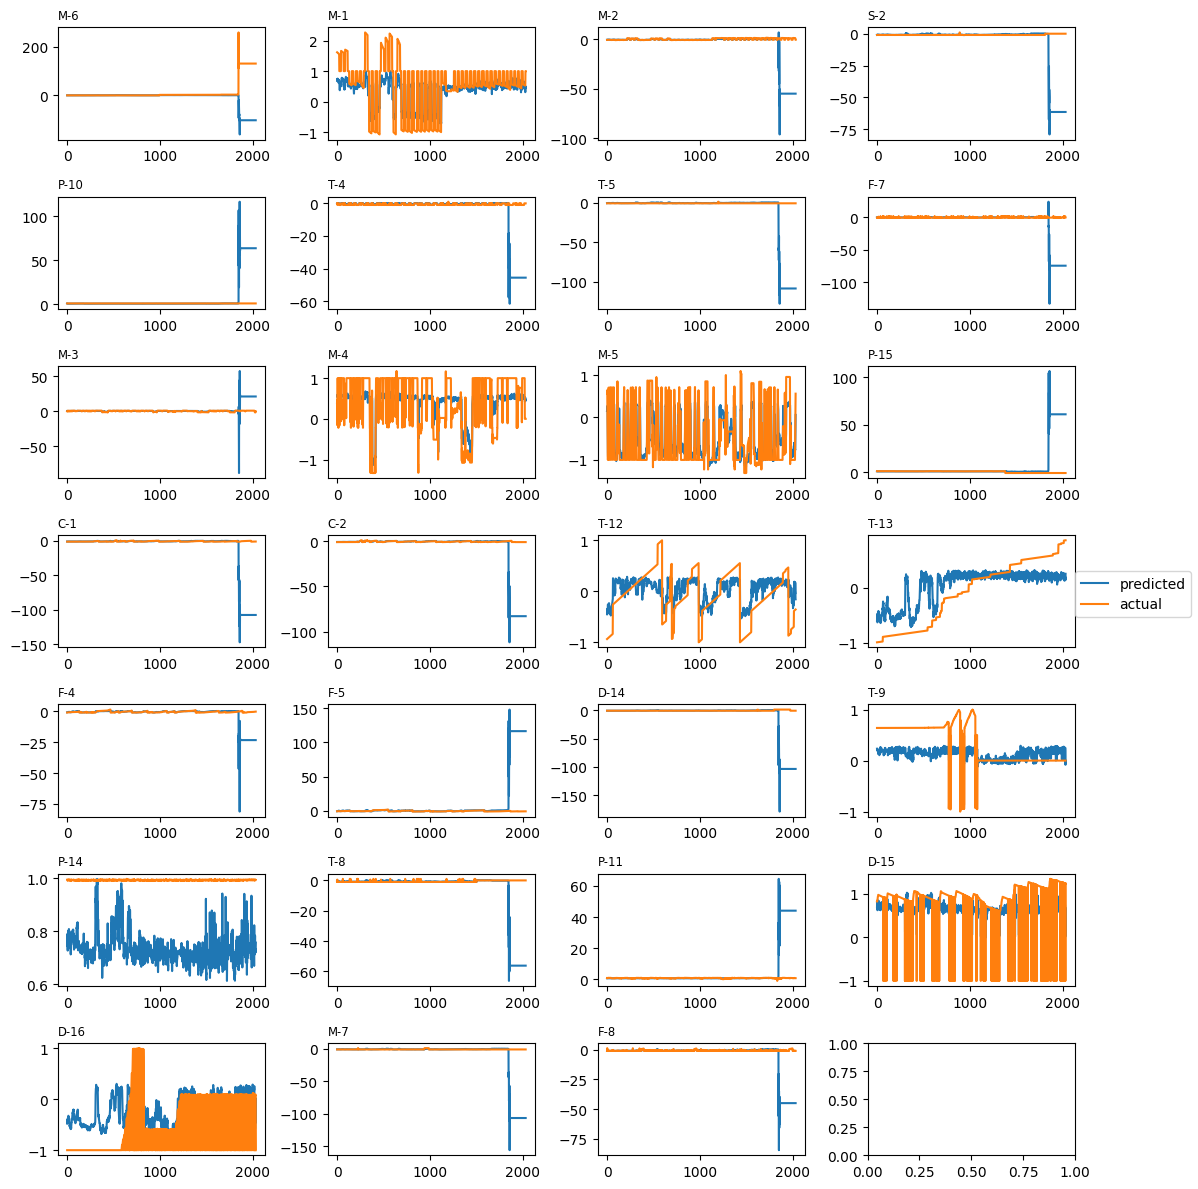

In [14]:
n_nodes = fitted_model.n_nodes

fig_cols = 4
fig_rows = n_nodes // fig_cols if n_nodes % fig_cols == 0 else n_nodes // fig_cols + 1

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    if i >= n_nodes:
        break
    test_predict, test_ground = fitted_model.test_result[:2, :, i]
    ax.plot(range(len(test_predict)), test_predict.T, label="predicted")
    ax.plot(range(len(test_ground)), test_ground.T, label="actual")
    ax.set_title(fitted_model.feature_list[i], fontsize="small", loc="left")

fig.legend(["predicted", "actual"], loc="right")
fig.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

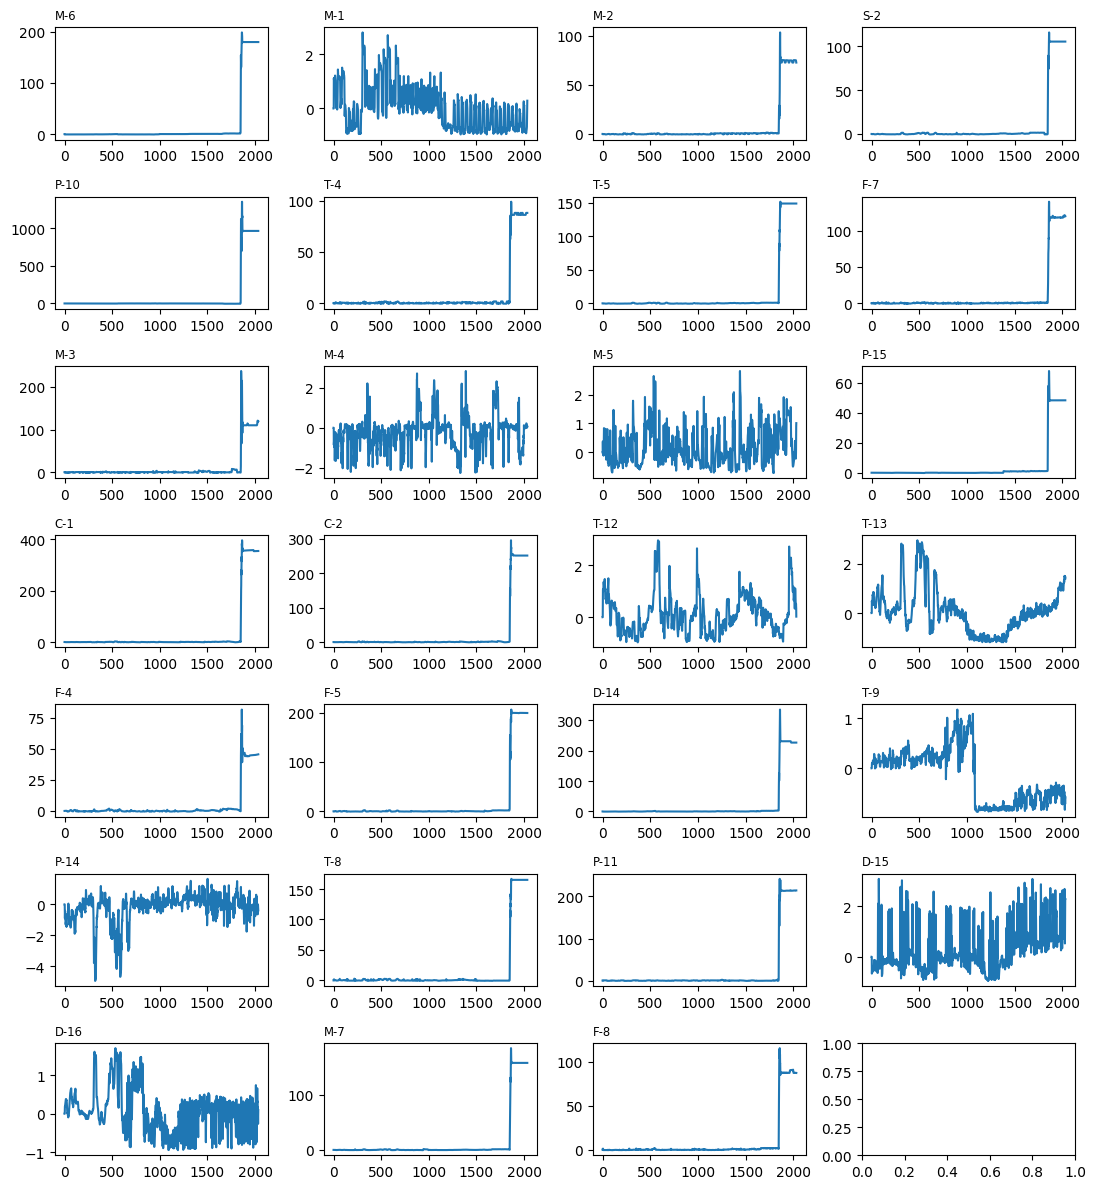

In [15]:
fig_cols = 4
fig_rows = n_nodes // fig_cols if n_nodes % fig_cols == 0 else n_nodes // fig_cols + 1

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    if i >= n_nodes:
        break
    err_score = fitted_model.test_err_scores[i, :]
    ax.plot(range(len(err_score)), err_score)
    ax.set_title(fitted_model.feature_list[i], fontsize="small", loc="left")

# fig.legend(['predicted', 'actual'], loc="right")
fig.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

In [16]:
fitted_model.threshold

10.156957494834156

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\matplotlib\collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


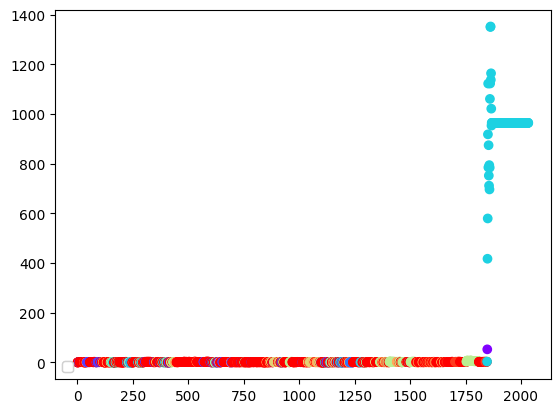

In [17]:
import matplotlib.cm as cm

list_integers = range(n_nodes)
cmap = cm.rainbow(np.array(list_integers) / np.mean(list_integers))
colors = [list(cmap[c]) for c in fitted_model.topk_err_indices[0]]

fig, ax = plt.subplots()
err_score = fitted_model.topk_err_scores
scatter = ax.scatter(range(len(err_score)), err_score, c=colors)

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left")
ax.add_artist(legend1)
# fitted_model.topk_err_indices[0]
plt.show()

In [18]:
for name, param in fitted_model.model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

embedding.weight torch.Size([27, 64])
bn_outlayer_in.weight torch.Size([64])
bn_outlayer_in.bias torch.Size([64])
gnn_layers.0.gnn.att_i torch.Size([1, 1, 64])
gnn_layers.0.gnn.att_j torch.Size([1, 1, 64])
gnn_layers.0.gnn.att_em_i torch.Size([1, 1, 64])
gnn_layers.0.gnn.att_em_j torch.Size([1, 1, 64])
gnn_layers.0.gnn.bias torch.Size([64])
gnn_layers.0.gnn.lin.weight torch.Size([64, 15])
gnn_layers.0.bn.weight torch.Size([64])
gnn_layers.0.bn.bias torch.Size([64])
out_layer.mlp.0.weight torch.Size([1, 64])
out_layer.mlp.0.bias torch.Size([1])


# Unit test

In [19]:
# -*- coding: utf-8 -*-
"""Tests for STRAY outlier estimator."""

__author__ = ["KatieBuc"]

import numpy as np
import pandas as pd
from sklearn.utils.validation import check_random_state

from refactor import GNNAD

random_state = 245
rng = check_random_state(random_state)

# generate multivariate data
cov = [[0.5, 0.3, 0], [0.3, 1.0, 0], [0, 0, 0.8]]
mean = [1, 3, 10]
X_train = (
    pd.DataFrame(rng.multivariate_normal(mean=mean, cov=cov, size=2000))
    .ewm(span=2)
    .mean()
)
X_test = (
    pd.DataFrame(rng.multivariate_normal(mean=mean, cov=cov, size=1000))
    .ewm(span=2)
    .mean()
)

# add anomalies to the test set
X_test.iloc[342:356, :] *= 2
X_test.iloc[752:772, 0:2] *= 0.01

# anomaly labels
y_test = np.zeros(len(X_test))
y_test[342:356] = 1
y_test[752:772] = 1


def test_fitted_model():
    """This model is tested against _[1], with the above generated code.
    To run the original code, this data needs to be saved as csv's locally.

    X_test['attack'] = y_test
    X_train.to_csv('data/unit_test/train.csv')
    X_test.to_csv('data/unit_test/test.csv')

    Then, in the terminal run:
    python main.py -dataset unit_test -device cpu -topk 2 -epoch 10

    References
    ----------
    _[1] https://github.com/d-ailin/GDN
    """

    model = GNNAD(shuffle_train=False, topk=2, epoch=10, save_model_name="test")
    fitted_model = model.fit(X_train, X_test, y_test)

    f1_actual = fitted_model.f1
    precision_actual = fitted_model.precision
    recall_actual = fitted_model.recall

    f1_expected = 0.5384615384615384
    precision_expected = 0.8235294117647058
    recall_expected = 0.4117647058823529

    assert np.allclose(f1_actual, f1_expected)
    assert np.allclose(precision_actual, precision_expected)
    assert np.allclose(recall_actual, recall_expected)


def test_fitted_model_val():
    """Test model detection for threshold as maximum A(t) from validation data.

    This model is tested against _[1], with the above generated code.
    To run the original code, this data needs to be saved as csv's locally.

    X_test['attack'] = y_test
    X_train.to_csv('data/unit_test/train.csv')
    X_test.to_csv('data/unit_test/test.csv')

    Then, in the terminal run:
    python main.py -dataset unit_test -device cpu -topk 2 -epoch 10 -report val

    References
    ----------
    _[1] https://github.com/d-ailin/GDN
    """

    model = GNNAD(
        shuffle_train=False,
        topk=2,
        epoch=10,
        threshold_type="max_validation",
        save_model_name="test",
    )
    fitted_model = model.fit(X_train, X_test, y_test)

    f1_actual = fitted_model.f1
    precision_actual = fitted_model.precision
    recall_actual = fitted_model.recall

    f1_expected = 0.23728813559322035
    precision_expected = 0.16666666666666666
    recall_expected = 0.4117647058823529

    assert np.allclose(f1_actual, f1_expected)
    assert np.allclose(precision_actual, precision_expected)
    assert np.allclose(recall_actual, recall_expected)


test_fitted_model()
test_fitted_model_val()

epoch (0 / 10) (Loss:40.17884064, ACU_loss:120.53652191)
epoch (1 / 10) (Loss:39.03404490, ACU_loss:117.10213470)
epoch (2 / 10) (Loss:37.60780589, ACU_loss:112.82341766)
epoch (3 / 10) (Loss:36.32013067, ACU_loss:108.96039200)
epoch (4 / 10) (Loss:35.13179779, ACU_loss:105.39539337)
epoch (5 / 10) (Loss:34.05962372, ACU_loss:102.17887115)
epoch (6 / 10) (Loss:34.34579849, ACU_loss:103.03739548)
epoch (7 / 10) (Loss:33.31120809, ACU_loss:99.93362427)
epoch (8 / 10) (Loss:32.25991440, ACU_loss:96.77974319)
epoch (9 / 10) (Loss:31.17664210, ACU_loss:93.52992630)
=========================** Result **============================

F1 score: 0.5384615384615384
precision: 0.8235294117647058
recall: 0.4117647058823529

epoch (0 / 10) (Loss:40.17884064, ACU_loss:120.53652191)
epoch (1 / 10) (Loss:39.03404490, ACU_loss:117.10213470)
epoch (2 / 10) (Loss:37.60780589, ACU_loss:112.82341766)
epoch (3 / 10) (Loss:36.32013067, ACU_loss:108.96039200)
epoch (4 / 10) (Loss:35.13179779, ACU_loss:105.3953